In [1]:
%matplotlib inline
import numpy as np
from scipy import stats
from utilities import plot_image_grid
from lol import lol_iid

"""
In this example we will form a grid based on linear combinations of three random latents in the Stable Diffusion 3 latent space.

We will then generate and display the corresponding grid images.
"""

np.random.seed(1)

# The object shape of the data and latents in Stable Diffusion 3.
# Note that the "data" in this model are not images, but VAE latents.
object_shape = [16, 96, 96]
# The latent distribution (of all elements) in the Stable Diffusion 3.
latent_distribution = stats.norm(loc=0, scale=1)

num_latent_dims = int(np.prod(object_shape))

# We will create a grid based on 3 seed latents.
# However, feel free to change the number of seed latents and what they are.
# The seeds latents should be drawn from the latent distribution,
# or obtained from e.g. inversion (which, if accurate and the data is supported, follow the latent distribution).
seed_latents = latent_distribution.rvs(size=[3, num_latent_dims])

X = seed_latents
num_grid_points_per_dim = 9

# Determine the linear combination weights w for each grid point ###############
w_grid = np.stack(
  np.meshgrid(
    np.linspace(0, 1, num=num_grid_points_per_dim),
    np.linspace(0, 1, num=num_grid_points_per_dim),
  ),
  axis=-1
).reshape(-1, 2)
num_grid_points = len(w_grid)

"""
We will let
 * x_1 be the upper left corner of the grid (weights [1, 0, 0]),
 * x_2 be the lower left corner (weights [0, 1, 0]),
 * x_3 be the upper right corner (weights [0, 0, 1]), and
 * -x_1 be the lower right corner (weights [-1, 0, 0]).
"""
w_remaining = 1 - np.sum(w_grid, axis=-1, keepdims=True)
w_grid_including_remaining = np.concatenate((w_remaining, w_grid), axis=-1)
###############################################################################

# When we have the weights w for each linear combination we use them form valid latents,
# having the same distribution as the seeds, i.e. following the latent distribution.
latents = lol_iid(
  w=w_grid_including_remaining,
  X=seed_latents,
  cdf=latent_distribution.cdf,
  inverse_cdf=latent_distribution.ppf
)

/home/erik/git/lol/linear-combinations-of-latents/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 60/60 [00:11<00:00,  5.31it/s]


Seed latent: 1


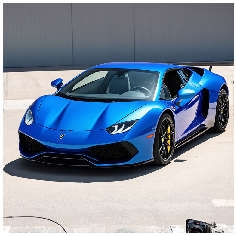

100%|██████████| 60/60 [00:10<00:00,  5.98it/s]


Seed latent: 2


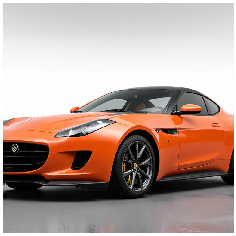

100%|██████████| 60/60 [00:10<00:00,  5.98it/s]


Seed latent: 3


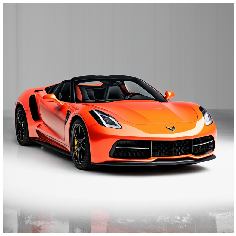

In [2]:
from diffusers import StableDiffusion3Pipeline, DDIMInverseScheduler, AutoencoderKL, DDIMScheduler
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_id = "stabilityai/stable-diffusion-3-medium-diffusers"
dtype = torch.float16

pipeline = StableDiffusion3Pipeline.from_pretrained(model_id, torch_dtype=dtype)
pipeline = pipeline.to(device)
num_inference_steps = 60
guidance_scale = 7.0
height, width = 768, 768

prompt = """
A high-quality photo of a parked, colored sports car taken with a DLSR camera with a 45.7MP sensor.
The entire sports car is visible in the centre of the image.
The background is simple and uncluttered to keep the focus on the sports car, with natural lighting enhancing its features.
"""

def generate(latent):
  latent_object = np.reshape(latent, (1, *object_shape))
  with torch.no_grad():
    image = pipeline(
      prompt=prompt,
      latents=torch.tensor(latent_object, device=device, dtype=dtype),
      height=height,
      width=width,
      guidance_scale=guidance_scale,
      num_inference_steps=num_inference_steps,
      num_images_per_prompt=1,
    ).images[0].convert('RGB')
    torch.cuda.empty_cache()
    return np.array(image, dtype=np.uint8)

for i, latent in enumerate(seed_latents):
  image = generate(latent)
  print("Seed latent:", i + 1)
  plot_image_grid(images=[image])

100%|██████████| 60/60 [00:11<00:00,  5.42it/s]


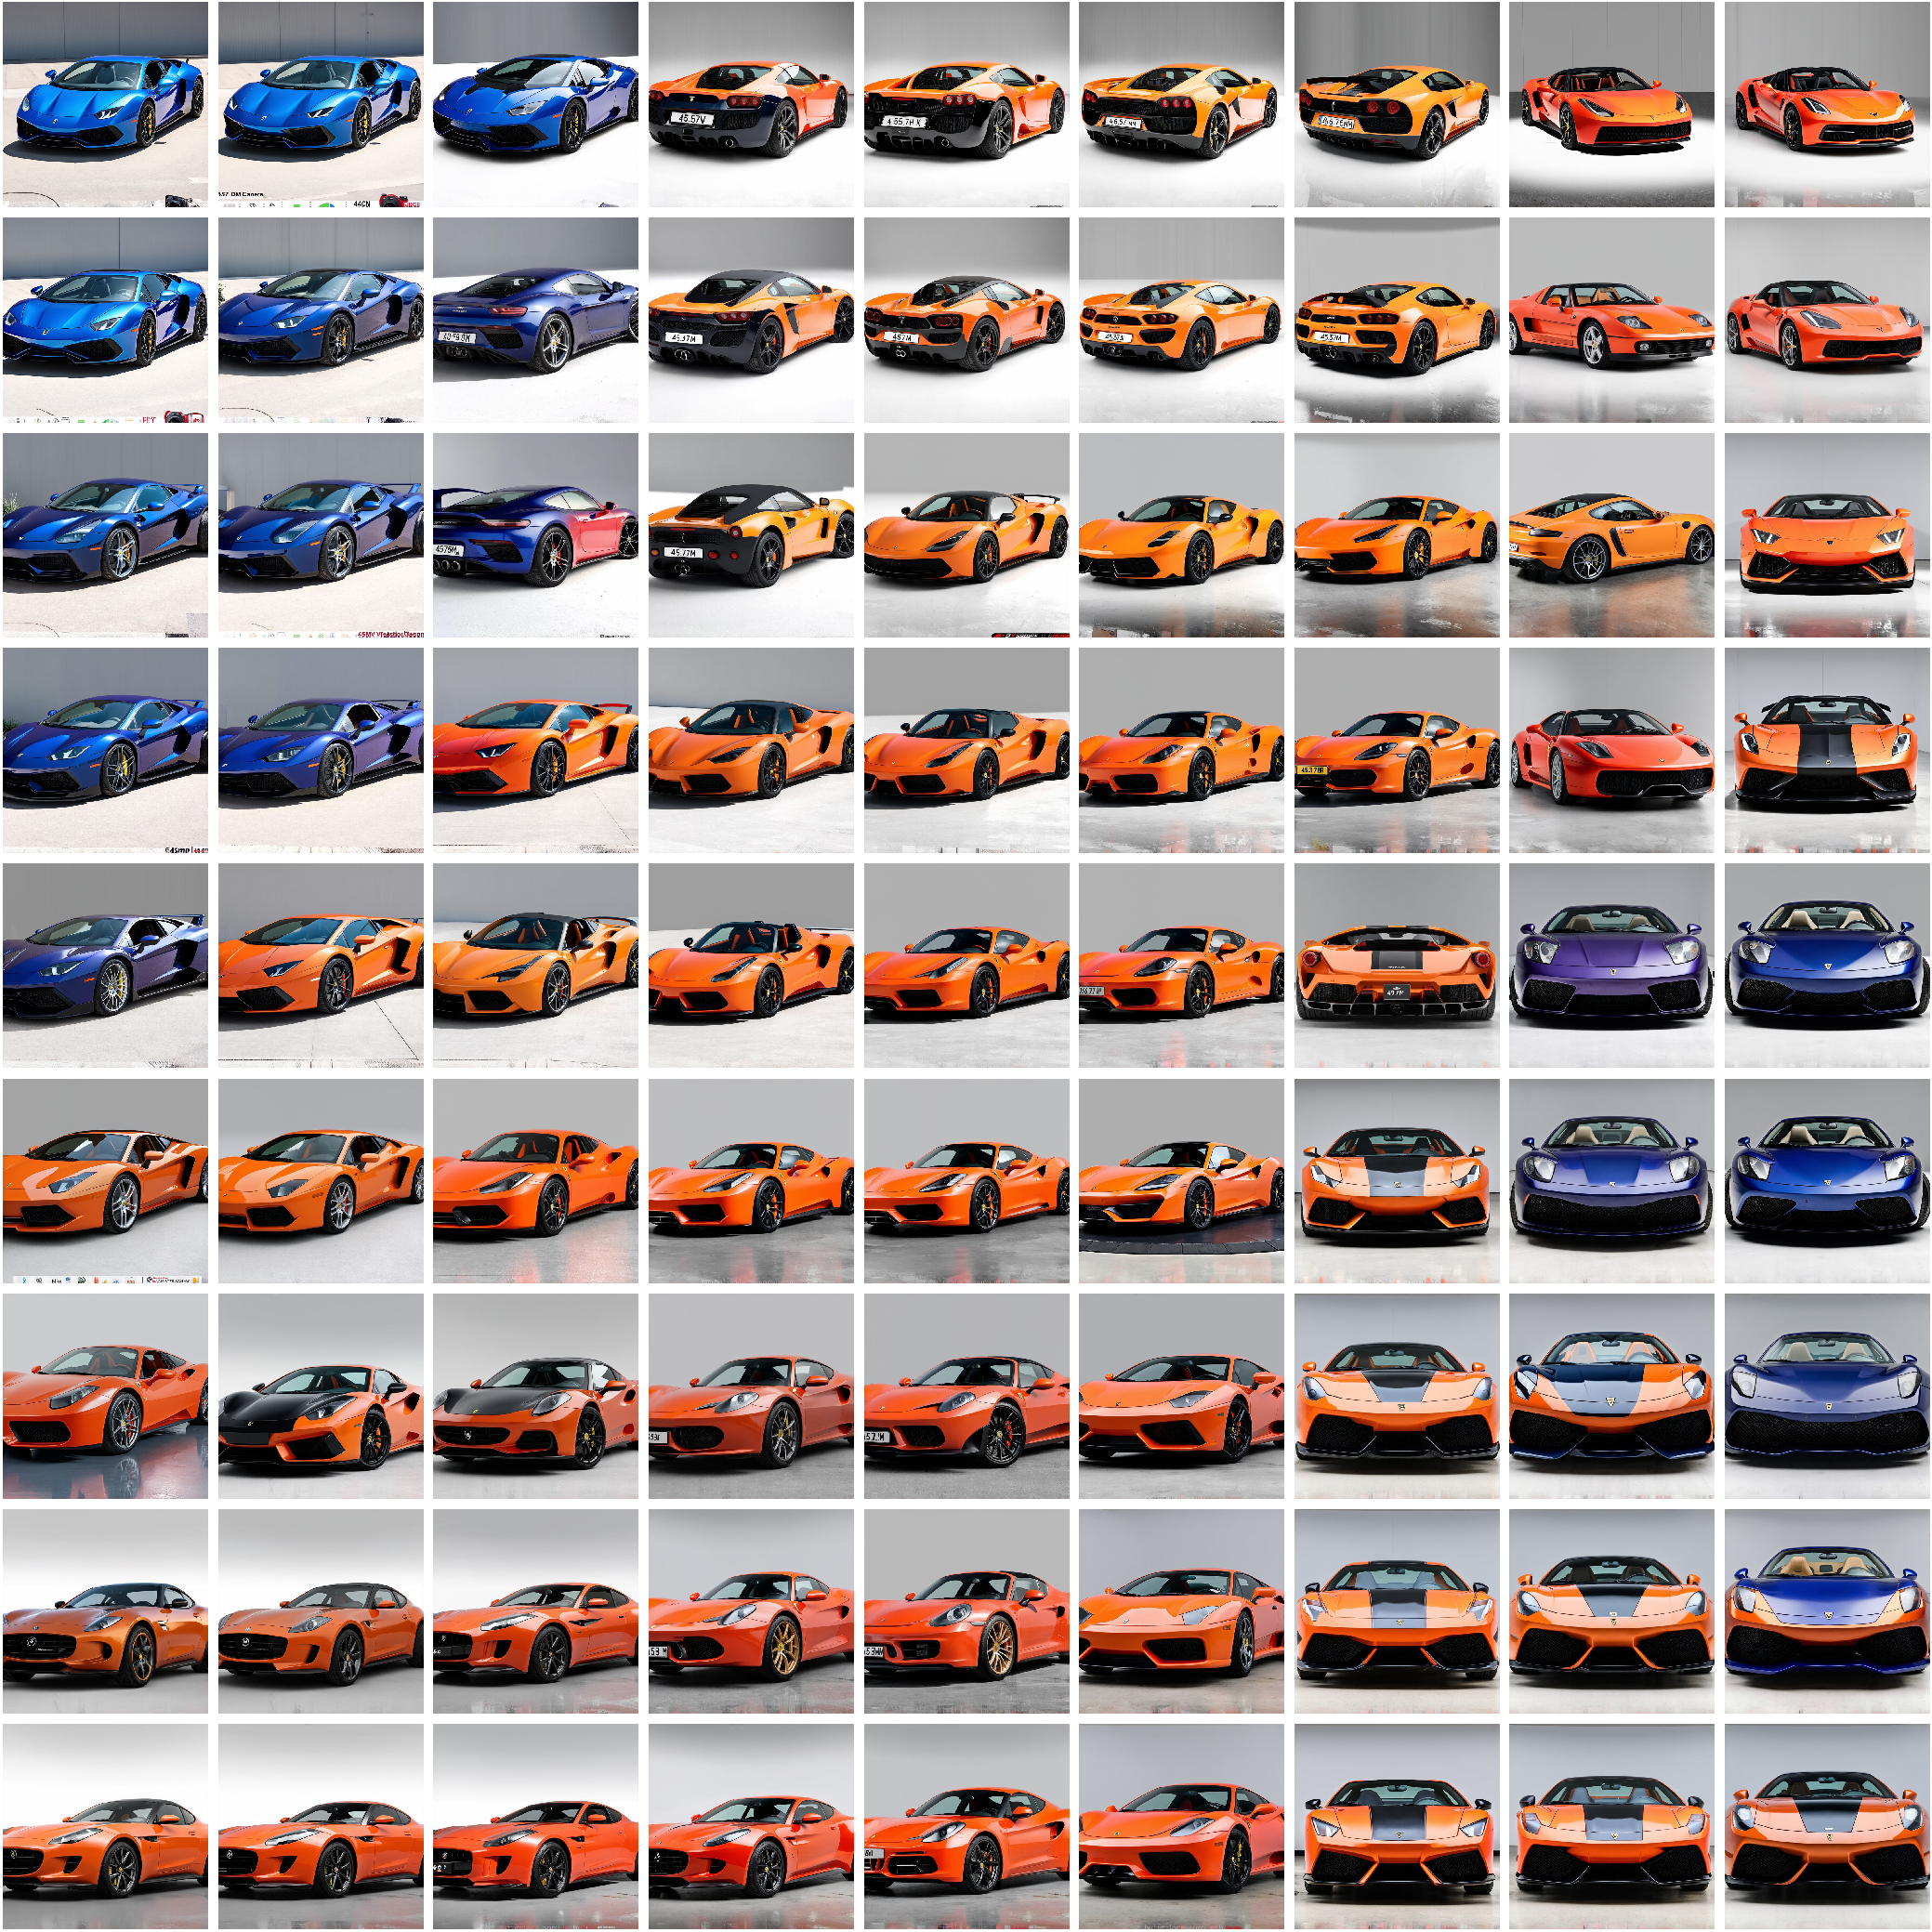

In [3]:
grid_positions = np.meshgrid(
  np.arange(num_grid_points_per_dim),
  np.arange(num_grid_points_per_dim),
)
grid_positions = np.stack(grid_positions, axis=-1).reshape(-1, 2)

image_per_latent = []
for i, latent in enumerate(latents):
  latent_object = np.reshape(latent, (1, *object_shape))
  image = generate(latent_object)
  image_per_latent.append(image)

plot_image_grid(
  images=[np.array(image, dtype=np.uint8) for image in image_per_latent],
  grid_positions=grid_positions
)